<a href="https://colab.research.google.com/github/usp787/CS5800_Final_Project_KV_Cache/blob/Code/kv_cache_code_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
import psutil
import os
from typing import Dict, List
import gc

In [2]:
# Configuration
CONFIG = {
    'output_lengths': [10, 25, 50, 75, 100, 250, 500, 750, 1000],
    'trials_per_length': 5,  # Increased for better statistics
    'warmup_runs': 3,  # Warmup runs per configuration
    'initial_prompt': "The future of artificial intelligence",
    'temperature': 0.7,
    'top_k': 50,
    'do_sample': True,
    'model_name': 'distilgpt2'
}

In [3]:
def setup_model_and_tokenizer():
    """Load model and tokenizer"""
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    model = AutoModelForCausalLM.from_pretrained(CONFIG['model_name'])

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set to evaluation mode

    print(f"Model loaded on: {device}")
    print(f"Model parameters: {model.num_parameters():,}")

    return model, tokenizer, device

In [4]:
def get_memory_usage() -> Dict[str, float]:
    """Get current memory usage in MB"""
    memory_data = {}

    if torch.cuda.is_available():
        torch.cuda.synchronize()  # Wait for all operations to complete
        memory_data['gpu_allocated_mb'] = torch.cuda.memory_allocated() / 1024 / 1024
        memory_data['gpu_reserved_mb'] = torch.cuda.memory_reserved() / 1024 / 1024

    return memory_data

In [5]:
def clear_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

In [6]:
def generate_tokens(
    model,
    tokenizer,
    device,
    prompt: str,
    max_new_tokens: int,
    use_cache: bool,
    measure_memory: bool = False
) -> Dict:
    """
    Generate tokens with or without KV cache

    Args:
        use_cache: If True, use KV cache; if False, disable it
    """
    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    prompt_length = input_ids.shape[1]

    # Clear memory before measurement
    if measure_memory:
        clear_memory()
        initial_memory = get_memory_usage()

    # Set cache configuration
    model.config.use_cache = use_cache

    # Synchronize GPU before timing
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    start_time = time.perf_counter()

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            use_cache=use_cache,
            do_sample=CONFIG['do_sample'],
            temperature=CONFIG['temperature'],
            top_k=CONFIG['top_k'],
            pad_token_id=tokenizer.pad_token_id,
            attention_mask=torch.ones_like(input_ids)  # Explicit attention mask
        )

    # Synchronize GPU after generation
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    end_time = time.perf_counter()
    generation_time = end_time - start_time

    # Measure memory after generation
    if measure_memory:
        final_memory = get_memory_usage()
        memory_used = {
            key: final_memory.get(key, 0) - initial_memory.get(key, 0)
            for key in initial_memory.keys()
        }
    else:
        memory_used = {}

    # Calculate metrics
    total_tokens = output.shape[1]
    tokens_generated = total_tokens - prompt_length

    return {
        'generation_time': generation_time,
        'tokens_generated': tokens_generated,
        'time_per_token': generation_time / tokens_generated if tokens_generated > 0 else 0,
        'prompt_length': prompt_length,
        'total_length': total_tokens,
        'memory_used': memory_used,
        'use_cache': use_cache
    }

In [7]:
def warmup_model(model, tokenizer, device, max_new_tokens: int, use_cache: bool):
    """Warmup the model to avoid first-run overhead"""
    print(f"  Warming up (use_cache={use_cache})...", end=" ")
    for _ in range(CONFIG['warmup_runs']):
        _ = generate_tokens(
            model, tokenizer, device,
            CONFIG['initial_prompt'],
            max_new_tokens,
            use_cache,
            measure_memory=False
        )
    clear_memory()
    print("✓")

In [8]:
def run_experiments(model, tokenizer, device):
    """Run complete experimental suite"""
    print("\n" + "="*80)
    print("STARTING KV CACHE COMPARISON EXPERIMENTS")
    print("="*80)
    print(f"Prompt: '{CONFIG['initial_prompt']}'")
    print(f"Output lengths: {CONFIG['output_lengths']}")
    print(f"Trials per configuration: {CONFIG['trials_per_length']}")
    print(f"Warmup runs: {CONFIG['warmup_runs']}")

    all_results = []

    for output_length in CONFIG['output_lengths']:
        print(f"\n{'─'*80}")
        print(f"Testing output length: {output_length} tokens")
        print(f"{'─'*80}")

        # Test both with and without cache
        for use_cache in [True, False]:
            cache_str = "WITH" if use_cache else "WITHOUT"
            print(f"\n{cache_str} KV Cache:")

            # Warmup for this configuration
            warmup_model(model, tokenizer, device, output_length, use_cache)

            # Run trials
            for trial in range(CONFIG['trials_per_length']):
                print(f"  Trial {trial + 1}/{CONFIG['trials_per_length']}...", end=" ")

                result = generate_tokens(
                    model, tokenizer, device,
                    CONFIG['initial_prompt'],
                    output_length,
                    use_cache,
                    measure_memory=(trial == 0)  # Only measure memory on first trial
                )

                # Store results
                result_record = {
                    'output_length': output_length,
                    'use_cache': use_cache,
                    'trial': trial + 1,
                    'generation_time_ms': result['generation_time'] * 1000,
                    'time_per_token_ms': result['time_per_token'] * 1000,
                    'tokens_generated': result['tokens_generated'],
                }

                # Add memory info if measured
                if result['memory_used']:
                    result_record.update({
                        f'{k}': v for k, v in result['memory_used'].items()
                    })

                all_results.append(result_record)

                print(f"✓ {result['generation_time']*1000:.2f}ms ({result['time_per_token']*1000:.2f}ms/token)")

                # Small delay between trials
                time.sleep(0.1)

    print("\n" + "="*80)
    print("EXPERIMENTS COMPLETE")
    print("="*80)

    return pd.DataFrame(all_results)

In [9]:
def analyze_results(df: pd.DataFrame):
    """Analyze and visualize experimental results"""
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS")
    print("="*80)

    # Group by output length and cache usage
    summary = df.groupby(['output_length', 'use_cache']).agg({
        'generation_time_ms': ['mean', 'std', 'min', 'max'],
        'time_per_token_ms': ['mean', 'std']
    }).round(2)

    print("\nGeneration Time Summary (ms):")
    print(summary)

    # Calculate speedup
    print("\n" + "─"*80)
    print("SPEEDUP ANALYSIS")
    print("─"*80)

    for length in df['output_length'].unique():
        with_cache = df[(df['output_length'] == length) & (df['use_cache'] == True)]['time_per_token_ms'].mean()
        without_cache = df[(df['output_length'] == length) & (df['use_cache'] == False)]['time_per_token_ms'].mean()
        speedup = without_cache / with_cache

        print(f"\nLength {length} tokens:")
        print(f"  WITH cache:    {with_cache:.2f} ms/token")
        print(f"  WITHOUT cache: {without_cache:.2f} ms/token")
        print(f"  Speedup:       {speedup:.2f}x")

    return summary

In [10]:
# Main execution
if __name__ == "__main__":
    # Setup
    model, tokenizer, device = setup_model_and_tokenizer()

    # Run experiments
    results_df = run_experiments(model, tokenizer, device)

    # Save raw results
    #results_df.to_csv('kv_cache_results.csv', index=False)
    #print("\nResults saved to 'kv_cache_results.csv'")

    # Analyze
    summary = analyze_results(results_df)

Loading model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on: cuda
Model parameters: 81,912,576

STARTING KV CACHE COMPARISON EXPERIMENTS
Prompt: 'The future of artificial intelligence'
Output lengths: [10, 25, 50, 75, 100, 250, 500, 750, 1000]
Trials per configuration: 5
Warmup runs: 3

────────────────────────────────────────────────────────────────────────────────
Testing output length: 10 tokens
────────────────────────────────────────────────────────────────────────────────

WITH KV Cache:
  Warming up (use_cache=True)... ✓
  Trial 1/5... ✓ 59.48ms (5.95ms/token)
  Trial 2/5... ✓ 58.54ms (5.85ms/token)
  Trial 3/5... ✓ 58.77ms (5.88ms/token)
  Trial 4/5... ✓ 64.26ms (6.43ms/token)
  Trial 5/5... ✓ 58.97ms (5.90ms/token)

WITHOUT KV Cache:
  Warming up (use_cache=False)... ✓
  Trial 1/5... ✓ 65.16ms (6.52ms/token)
  Trial 2/5... ✓ 60.62ms (6.06ms/token)
  Trial 3/5... ✓ 58.89ms (5.89ms/token)
  Trial 4/5... ✓ 62.99ms (6.30ms/token)
  Trial 5/5... ✓ 77.06ms (7.71ms/token)

──────────────────────────────────────────────────────

**Visualization**

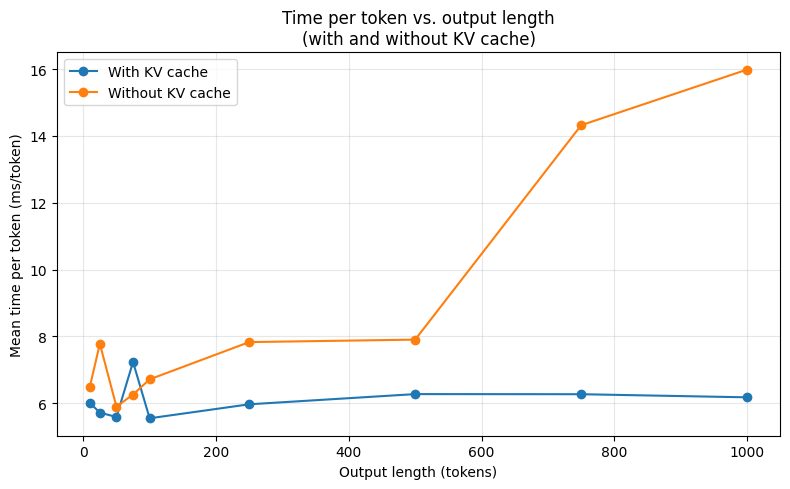

In [11]:
#Time per token vs output length (with vs without cache)
df = results_df.copy()

# Aggregate: mean time per token for each (output_length, use_cache)
agg = (
    df.groupby(['output_length', 'use_cache'])['time_per_token_ms']
      .mean()
      .reset_index()
)

# Map bool -> nice labels for plotting
agg['config'] = agg['use_cache'].map({True: 'With KV cache', False: 'Without KV cache'})

plt.figure(figsize=(8, 5))

for label in ['With KV cache', 'Without KV cache']:
    subset = agg[agg['config'] == label]
    plt.plot(
        subset['output_length'],
        subset['time_per_token_ms'],
        marker='o',
        linestyle='-',
        label=label,
    )

plt.xlabel('Output length (tokens)')
plt.ylabel('Mean time per token (ms/token)')
plt.title('Time per token vs. output length\n(with and without KV cache)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


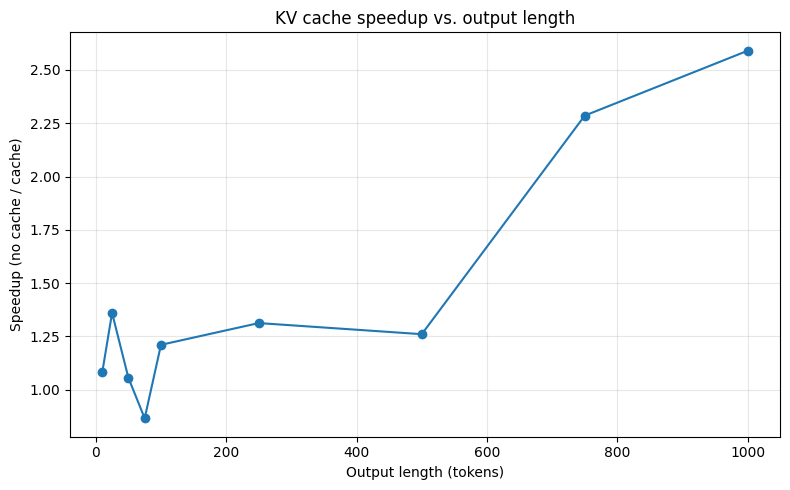

In [12]:
#Speedup vs output length
# Pivot to compute speedup = no_cache_time / cache_time
pivot = agg.pivot(index='output_length', columns='config', values='time_per_token_ms')

pivot['Speedup (x)'] = pivot['Without KV cache'] / pivot['With KV cache']

plt.figure(figsize=(8, 5))
plt.plot(
    pivot.index,
    pivot['Speedup (x)'],
    marker='o',
    linestyle='-'
)

plt.xlabel('Output length (tokens)')
plt.ylabel('Speedup (no cache / cache)')
plt.title('KV cache speedup vs. output length')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



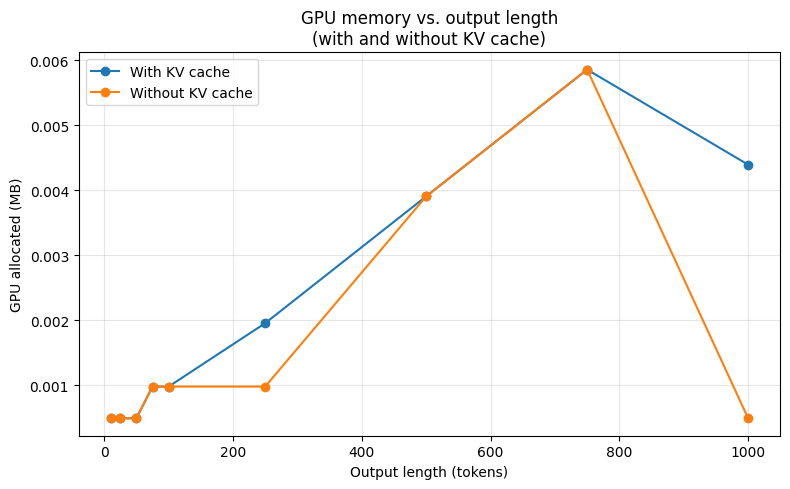

In [13]:
#GPU memory usage vs output length
# Only keep rows where memory was measured (trial == 1 in your code)
mem_df = df[df['trial'] == 1].copy()

mem_agg = (
    mem_df.groupby(['output_length', 'use_cache'])[['gpu_allocated_mb', 'gpu_reserved_mb']]
          .mean()
          .reset_index()
)

mem_agg['config'] = mem_agg['use_cache'].map({True: 'With KV cache', False: 'Without KV cache'})

plt.figure(figsize=(8, 5))
for label in ['With KV cache', 'Without KV cache']:
    subset = mem_agg[mem_agg['config'] == label]
    plt.plot(
        subset['output_length'],
        subset['gpu_allocated_mb'],
        marker='o',
        linestyle='-',
        label=label
    )

plt.xlabel('Output length (tokens)')
plt.ylabel('GPU allocated (MB)')
plt.title('GPU memory vs. output length\n(with and without KV cache)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
